In [2]:
from logLikeli import logLike

import numpy as np
import pymaster as nmt
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt 
import imp
import camb

from astropy.io import fits as fits

from scipy.linalg import sqrtm

from numpy import linalg as LA
%matplotlib inline

In [3]:
import utils

In [4]:
from utils import Marray_EEfirst as Marray
from utils import Minv as Minv
from utils import evaluateLikelihood as evaluateL

In [24]:
import dynesty
from dynesty import plotting as dyplot
## import planck function 
from pysm.common import B as pf
from Fg_template import sync_ps, dust_ps

## data

In [6]:
A_d_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_template_353_BB_RJ.npy')
dust_dl_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/dust_BB_cross_fre_1p56_from_RJ.npy')

A_s_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_template_30_BB_RJ.npy')
sync_dl_RJ = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0629_2fre_Ali/sync_BB_cross_fre_n3p0_from_RJ.npy')

In [64]:
path = '/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise'

cl_f_all_ali = np.load('%s/cl_f_all.npy'%path); cl_f_ali = np.mean(cl_f_all_ali, axis = 0)

## to include the dust and sync cross ps into the fiducial ps. Only BB for now; 2020.07.13
# cl_f_all_ali[:,2] +=  sync_dl_RJ + dust_dl_RJ #

# cl_hat_all_ali = np.load('%s/cl_hat_fore_all.npy'%path) 
# cl_hat_0_ali = cl_hat_all_ali[10]

cl_hat_all_ali = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0710_2fre_Ali_real_fore_and_noise/cl_hat_r0_all.npy')

nl_all_ali = np.load('%s/nl_all.npy'%path)
nl_mean_ali = np.mean(nl_all_ali, axis = 0) ## EE EB BB

In [8]:
cl_camb = np.load('/fnx/jianyao/Likelihood_data/Bandpowers/0627_2fre_fullsky/cl_camb_BB_2fre.npy')
cl_th_BB_ali = cl_camb + nl_mean_ali[2]

In [8]:
lensingB = utils.Gencl(r = 0, raw_cl = True) ## only lensing BB; TT EE BB TE

bb_05 = utils.Gencl(r = 0.05, raw_cl = True, tensorBB_only=True) ##only tensor BB; ## 

In [60]:
cmb_bb = lensingB[2] + bb_05

b.bin_cell(cmb_bb[0:nmtlmax+1])

## Method

In [9]:
from utils import testL as testL

In [66]:
LogL = logLike(2,10) 

 ## calculate logL.cl_f; logL.Cov  

LogL.M(cl_f_all = cl_f_all_ali, SamNum=500)

In [63]:
SamNum = 500

In [102]:
# LogL.run(cl_hat=cl_hat_0_ali[2], cl_th=cl_th_BB_ali, sbin=1)

In [39]:
nside = 128
nmtlmax = 201
lmin = 2
lmax = 1521

Nf = 2

b = nmt.NmtBin(nside, nlb=20, is_Dell=True, lmax=nmtlmax)
leff = b.get_effective_ells()
lbin = len(leff)
b_ind = np.arange(1,lbin+1)

In [67]:
cl_hat_all_ali.shape

(500, 3, 10, 2, 2)

In [76]:
def prior(cube):
    
    r = cube[0]*2 - 1
    beta_s = cube[1]*2 - 4## from -4 to -2
    beta_d = cube[2] + 1 ## from 1 to 2
        
    return [r, beta_s, beta_d]

Mean = np.zeros((100, 3))
for n in range(100):
    
    cl_hat_fore_ali = cl_hat_all_ali[n][2]
    def log_likelihood(cube, subtract = False):
        r_i = cube[0];
        beta_s = cube[1];
        beta_d = cube[2];

        bb_tensor = bb_05[0:nmtlmax+1]*r_i/0.05 

        bb_camb = bb_tensor + lensingB[2][0:nmtlmax+1] ## tensor BB + lensing BB 

        cl_th_i = b.bin_cell(bb_camb[0:nmtlmax+1])  ## theoretical bandpower 
        cl_th_test = np.ones((lbin, Nf, Nf));  ## BB cross power spectra
        for ell in range(lbin):
            cl_th_test[ell] *= cl_th_i[ell]

        if subtract:

            # add Noise bias N_l to expectation values.########################## Noise level
            C_l = cl_th_test + nl_mean_ali[2] 

            logL = LogL.run(cl_hat=(cl_hat_fore_ali- sync_ps(A_s_RJ, beta_s, 10) - dust_ps(A_d_RJ, beta_d, 10)) , cl_th = C_l,sbin=1);

        else:
            C_l = cl_th_test + nl_mean_ali[2] + sync_ps(A_s_RJ, beta_s, 10) + dust_ps(A_d_RJ, beta_d, 10);

            logL =LogL.run(cl_hat=(cl_hat_fore_ali) , cl_th = C_l, sbin=1);   

        return np.real(logL)
    
    sampler = dynesty.NestedSampler(log_likelihood, prior, 3, nlive=400)
    sampler.run_nested()
    results = sampler.results

    samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
    mean, cov = dyfunc.mean_and_cov(samples, weights) 
    
    Mean[n] = mean

Text(0, 0.5, 'n')

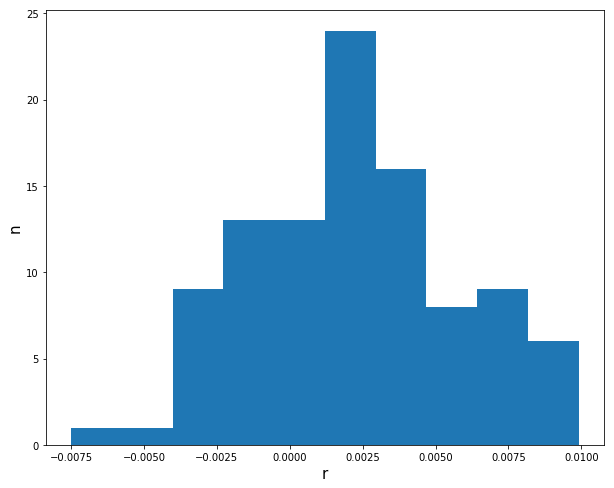

In [69]:
plt.figure(figsize = (10,8))
plt.hist(Mean[:,0])
plt.xlabel('r', fontsize = 15); plt.ylabel('n', fontsize = 15)

In [74]:
np.std(Mean[:,0])

0.0035538644729528274

In [71]:
np.mean(Mean[:,0])

0.0022414321753012906

Text(0, 0.5, 'n')

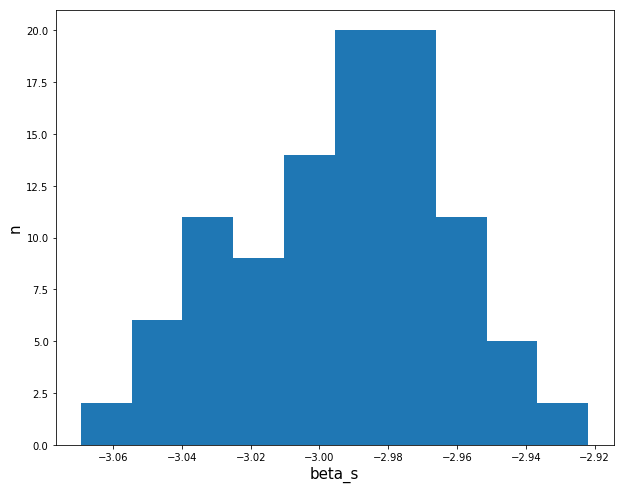

In [72]:
plt.figure(figsize = (10,8))
plt.hist(Mean[:,1])
plt.xlabel('beta_s', fontsize = 15); plt.ylabel('n', fontsize = 15)

In [75]:
np.mean(Mean[:,2])

1.5492298671684364

Text(0, 0.5, 'n')

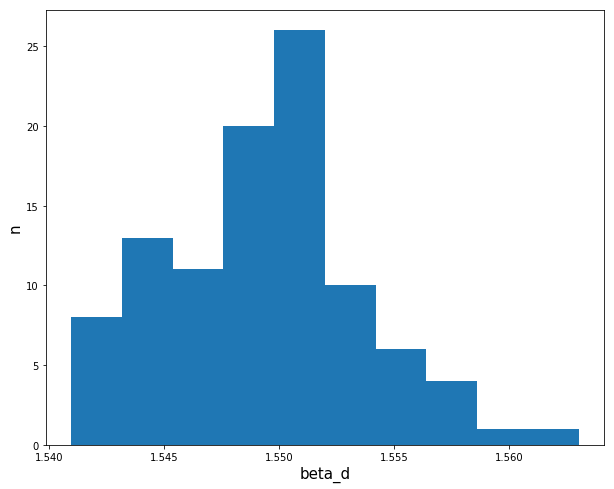

In [73]:
plt.figure(figsize = (10,8))
plt.hist(Mean[:,2])
plt.xlabel('beta_d', fontsize = 15); plt.ylabel('n', fontsize = 15)

In [32]:
from dynesty import utils as dyfunc 

samples, weights = results.samples, np.exp(results.logwt - results.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights) 

In [43]:
truth = np.array([0, -3.0, 1.558])

sig1 = [0.16, 0.5, 0.84]; sig2 = [0.021, 0.5, 0.979];

(<Figure size 1080x720 with 9 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb4832a588>,
       dtype=object))

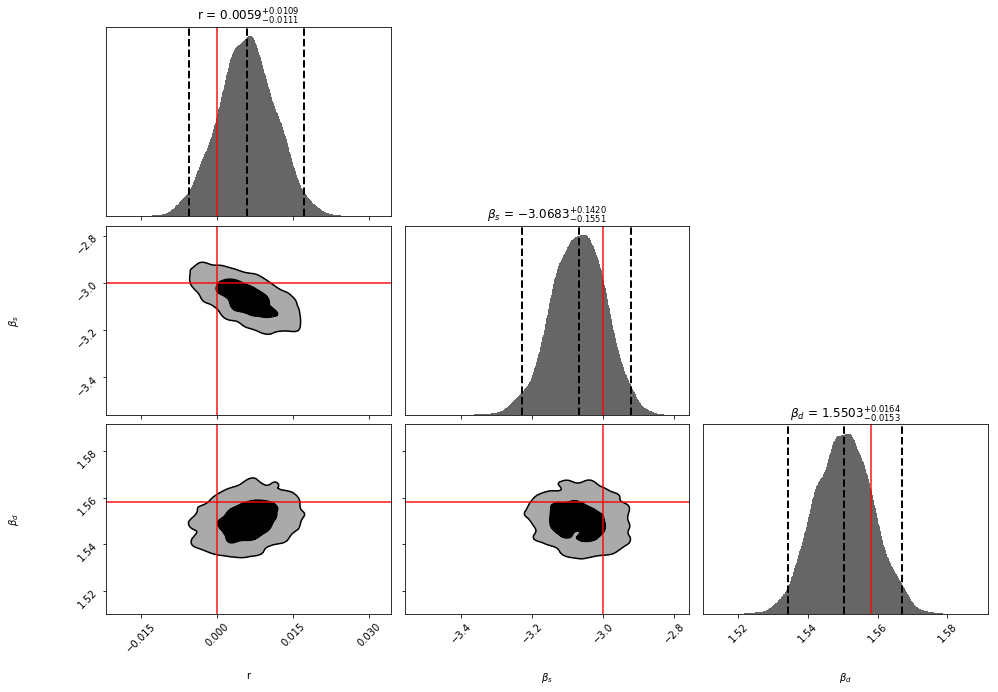

In [44]:
## cl_hat_r0

labels = ['r',r'$\beta_s$',r'$\beta_d$']
fig, axes = plt.subplots(3, 3, figsize=(15, 10))
axes = axes.reshape((3, 3)) 

dyplot.cornerplot(results,  truths=truth, fig = (fig, axes), title_fmt='.4f', show_titles=True,
                 labels = labels,quantiles = sig2, quantiles_2d = [0.4,0.85]) #0.1, 0.4, 0.65, 0.85

# plt.savefig('./fig_results/dynesty/cl_hat_r0_fiducial_only_CMB_Noise.pdf', format = 'pdf')